# EDA

In [1]:
import pybgpstream
import pandas as pd

## Cloudflare 1.1.1.1 incident on June 27, 2024

https://blog.cloudflare.com/cloudflare-1111-incident-on-june-27-2024/

Some of the difficulty comes from potential routing hijacks of 1.1.1.1. For example, if some fictitious FooBar Networks assigns 1.1.1.1/32 to one of their routers and shares this prefix within their internal network, their customers will have difficulty routing to the 1.1.1.1 DNS service. If they advertise the 1.1.1.1/32 prefix outside their immediate network, the impact can be even greater. The reason 1.1.1.1/32 would be selected instead of the 1.1.1.0/24 BGP-announced by Cloudflare is due to Longest Prefix Matching (LPM). While many prefixes in a route table could match the 1.1.1.1 address, such as 1.1.1.0/24, 1.1.1.0/29, and 1.1.1.1/32, 1.1.1.1/32 is considered the “longest match” by the LPM algorithm because it has the highest number of identical bits and longest subnet mask while matching the 1.1.1.1 address. In simple terms, we would call 1.1.1.1/32 the “most specific” route available to 1.1.1.1.

- **2024-06-27 18:51:00** `AS267613` (Eletronet) begins announcing 1.1.1.1/32 to peers, providers, and customers. 1.1.1.1/32 is announced with the AS267613 origin AS

- **2024-06-27 22:16:00** AS262504 leaks 1.1.1.0/24 again, attracting some traffic to a Cloudflare peering with `AS267613` in São Paulo. Some 1.1.1.1 requests as a result are returned with higher latency, but the hijack of 1.1.1.1/32 and traffic blackholing appears resolved

### Get data

In [ ]:
# collector = "route-views.eqix"
# collector = "route-views.ny" 
# collector = "route-views.telxatl"
# collector = "route-views2.saopaulo"
# collector = "route-views.fortaleza"
collector = "route-views.amsix"

stream = pybgpstream.BGPStream(
    #project="route-views",          # Proyecto
    collectors  =   [collector],#     # Collector remoto
    record_type =   "updates",             # "ribs" o "updates"
    from_time   =   "2024-06-27 18:00:00",  # Inicio del rango
    until_time  =   "2024-06-27 22:30:00",     # Fin del rango (aquí 5 minutos)
)

""" rows = []

# Iterar sobre los registros en tiempo real o históricos
for rec in stream.records():
    for elem in rec:
        fields = elem.fields
        rows.append({
            "time": rec.time,
            "project": rec.project,
            "collector": rec.collector,
            "peer_asn": fields.get("peer-asn"),
            "peer_ip": fields.get("peer-address"),
            "type": elem.type,           # "RIB", "A" (announce), "W" (withdraw)
            "prefix": fields.get("prefix"),
            "next_hop": fields.get("next-hop"),
            "as_path": fields.get("as-path"),
            "origin": fields.get("origin"),
            "local_pref": fields.get("local-pref"),
            "med": fields.get("med"),
            "communities": fields.get("communities"),
        }) """

rows = []

for rec in stream.records():
    for elem in rec:
        f = elem.fields  # solo atributos BGP (no peers)

        # Para retiros (W) no hay as-path/next-hop/etc.
        is_announce = (elem.type == 'A')

        rows.append({
            "time": rec.time,                        # epoch (int)
            "project": rec.project,                  # p.ej. "route-views"
            "collector": rec.collector,              # p.ej. "route-views.sg"
            "peer_asn": elem.peer_asn,               # <--- AQUÍ
            "peer_ip": elem.peer_address,            # <--- AQUÍ
            "type": elem.type,                       # "A" o "W"
            "prefix": f.get("prefix"),
            "next_hop": f.get("next-hop") if is_announce else None,
            "as_path": f.get("as-path")  if is_announce else None,
            "origin": f.get("origin")    if is_announce else None,
            "local_pref": f.get("local-pref") if is_announce else None,
            "med": f.get("med")                  if is_announce else None,
            "communities": f.get("communities") if is_announce else None,
        })

# Convertir a DataFrame
df = pd.DataFrame(rows)

#pd.set_option('display.max_rows', None)

print(f'Dataframe with {len(df):,} rows')

Dataframe with 11,628,213 rows


In [3]:
df['formatted_time'] = pd.to_datetime(df['time'], unit='s', utc=True)
df['formatted_time'] = df['formatted_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df.head(5)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1070::/32,2001:7f8:1:0:a500:26:7613:1,267613 28209,None,None,None,"{5469:11111, 5469:2400, 5469:10110}",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1624:9000::/36,2001:7f8:1:0:a500:26:7613:1,267613 174 263444 263270,None,None,None,"{5469:10850, 5469:11000, 5469:2200}",2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a06:de05:61dc::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 174 53667,None,None,None,"{5469:10850, 5469:11000, 5469:2200}",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.amsix,56662,2001:7f8:f2:e1:0:a105:6662:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:a105:6662:1,56662 34549 3257 174 53667,None,None,None,{56662:65008},2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.amsix,213151,2001:7f8:f2:e1:0:21:3151:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:21:3151:1,213151 34549 3257 174 53667,None,None,None,{},2024-06-27 18:00:00


#### Save data

In [4]:
df.to_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
              engine='pyarrow',
              compression='zstd')

In [5]:
del df

## Load data from file

### Funciones auxiliares

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plot_counts_per_type(df_: pd.DataFrame):
    """
    Grafica la catidad de datos por tipo (A/W).
    
    Parámetros
    ----------
    df_ : pd.DataFrame
        Debe incluir las columnas: ['type'].

    Returns
    -------
    None
    """
    df = df_.copy()
    df_types = (
        df['type']
        .value_counts()
        .reset_index()
    )

    display(df_types)

    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=df_types, x='type', y='count', palette='Set2', hue='type')
    plt.title('Counts per Type')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.show()

def plot_updates_by_type(df_: pd.DataFrame, grain: str = "1min", group_col: str = None):
    """
    Grafica la distribución temporal de eventos BGP por tipo (A/W).
    
    Parámetros
    ----------
    df_ : pd.DataFrame
        Debe incluir las columnas: ['formatted_time', 'type'].
        'formatted_time' puede ser string '%Y-%m-%d %H:%M:%S' o datetime.
    grain : str
        Frecuencia de agregación temporal (p.ej. '1S', '1min', '5min', '1H').
    group_col : str, opcional
        Nombre de una columna del DataFrame. Si se especifica, se generará un
        gráfico por cada valor distinto de esa columna (small multiples).
        Si no se especifica, se grafica una sola serie agregada globalmente.

    Returns
    -------
    None
    """

    df = df_.copy()
    if group_col is None:
        # Agregado global por tiempo y tipo
        df['formatted_time'] = pd.to_datetime(df['formatted_time'], utc=True, errors='coerce')
        agg = (
            df.groupby([pd.Grouper(key='formatted_time', freq=grain), 'type'])
                .size()
                .reset_index(name='count')
                .sort_values('formatted_time')
        )

        # Plot único (A vs W)
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=agg, x='formatted_time', y='count', hue='type', estimator=None)
        plt.title(f'Eventos BGP por tipo (A/W) en el tiempo — {grain}')
        plt.xlabel('Tiempo'); plt.ylabel('Número de eventos')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:

        if isinstance(df[group_col].dtype, pd.CategoricalDtype):
            df[group_col] = df[group_col].cat.remove_unused_categories()
        # Agregado por tiempo, grupo y tipo
        agg = (
            df.groupby([pd.Grouper(key='formatted_time', freq=grain), group_col, 'type'])
                .size()
                .reset_index(name='count')
                .sort_values('formatted_time')
        )

        # Small multiples: un panel por valor de group_col
        g = sns.FacetGrid(
            agg, col=group_col, hue='type', sharey=False, sharex=True, col_wrap=3, height=3.2, aspect=1.6
        )
        g.map_dataframe(sns.lineplot, x='formatted_time', y='count', estimator=None)
        g.add_legend(title='type')
        g.set_xticklabels(rotation=30)
        g.set_axis_labels('Tiempo', 'Número de eventos')
        g.set_titles(col_template=f'{group_col} = {{col_name}}')
        for ax in g.axes.flatten():
            ax.grid(True, alpha=0.3)
        plt.subplots_adjust(top=0.88)
        g.fig.suptitle(f'Eventos BGP por tipo (A/W) en el tiempo — {grain}', y=1.02)
        plt.tight_layout()
        plt.show()

def add_as_path_length(df_: pd.DataFrame, columns: list):
    df = df_.copy()
    
    df['as_path_length'] = (
        df['as_path']
        .fillna('') # Para que los None no den error
        .apply(lambda x: len(str(x).split()) if x != '' else 0)
    )
    df = df[columns]
    return df

In [ ]:
#pd.set_option('display.max_rows', None) # Mostrar todas las filas cuando se imprime el dataframe

In [3]:
new_column_order = ['time', 'formatted_time', 'project', 'collector', 'peer_asn', 'peer_ip', 'type', 'prefix', 'next_hop', 'as_path', 'as_path_length', 'origin', 'local_pref', 'med', 'communities']

### Route Views EQIX

In [4]:
collector = "route-views.eqix"

df_eqix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_eqix.head(5)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.eqix,37468,206.126.238.56,A,169.145.140.0/23,206.126.238.64,37468 8220 14114 6979 6979 6979 6979 6979 6979,None,None,None,"[37468:2410, 37468:2000, 37468:14102, 37468:14...",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.eqix,3257,206.126.236.19,W,45.172.92.0/22,None,None,None,None,None,None,2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.eqix,3257,2001:504:0:2::3257:1,A,2a10:ccc7:9367::/48,2001:504:0:2::3257:1,3257 2914 2914 2914 20473,None,None,None,"[3257:51105, 3257:50002, 3257:8162, 3257:51100...",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.eqix,6939,2001:504:0:2::6939:1,A,2c0f:fda8::/32,2001:504:0:2::6939:1,6939 37662 9498 36926 327708 37133 37349,None,None,None,[],2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.eqix,41095,206.126.236.120,W,197.216.52.0/24,None,None,None,None,None,None,2024-06-27 18:00:00


In [5]:
df_eqix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240184 entries, 0 to 7240183
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 773.3+ MB


In [6]:
eqix_null_stats = pd.DataFrame({
    'nulos': df_eqix.isna().sum(),
    'no_nulos': df_eqix.notna().sum(),
    'pct_nulos': (df_eqix.isna().sum() / len(df_eqix) * 100).round(2)
})
display(eqix_null_stats)

,nulos,no_nulos,pct_nulos
time,0,7240184,0.00
project,0,7240184,0.00
collector,0,7240184,0.00
peer_asn,0,7240184,0.00
peer_ip,0,7240184,0.00
type,0,7240184,0.00
prefix,0,7240184,0.00
next_hop,460296,6779888,6.36
as_path,460296,6779888,6.36
origin,7240184,0,100.00


In [7]:
df_eqix = add_as_path_length(df_eqix, new_column_order)
df_eqix.head(5)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.eqix,37468,206.126.238.56,A,169.145.140.0/23,206.126.238.64,37468 8220 14114 6979 6979 6979 6979 6979 6979,9,None,None,None,"[37468:2410, 37468:2000, 37468:14102, 37468:14..."
1,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.eqix,3257,206.126.236.19,W,45.172.92.0/22,None,None,0,None,None,None,None
2,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.eqix,3257,2001:504:0:2::3257:1,A,2a10:ccc7:9367::/48,2001:504:0:2::3257:1,3257 2914 2914 2914 20473,5,None,None,None,"[3257:51105, 3257:50002, 3257:8162, 3257:51100..."
3,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.eqix,6939,2001:504:0:2::6939:1,A,2c0f:fda8::/32,2001:504:0:2::6939:1,6939 37662 9498 36926 327708 37133 37349,7,None,None,None,[]
4,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.eqix,41095,206.126.236.120,W,197.216.52.0/24,None,None,0,None,None,None,None


In [8]:
df_eqix[df_eqix['prefix'].isin(['1.1.1.1/32','1.1.1.1/24'])]

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
1465049,1.719514e+09,2024-06-27 18:52:57,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,2,None,None,None,[]
2193539,1.719516e+09,2024-06-27 19:16:27,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,0,None,None,None,None
2267139,1.719516e+09,2024-06-27 19:18:59,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,2,None,None,None,[]
2777146,1.719517e+09,2024-06-27 19:41:47,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,0,None,None,None,None
2853716,1.719518e+09,2024-06-27 19:46:01,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,2,None,None,None,[]
3418875,1.719519e+09,2024-06-27 20:07:48,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,0,None,None,None,None
3538161,1.719519e+09,2024-06-27 20:11:49,routeviews,route-views.eqix,398465,206.126.236.209,A,1.1.1.1/32,206.126.236.209,398465 267613,2,None,None,None,[]
4090674,1.719520e+09,2024-06-27 20:33:25,routeviews,route-views.eqix,398465,206.126.236.209,W,1.1.1.1/32,None,None,0,None,None,None,None


In [9]:
df_eqix_as_267613 = df_eqix[df_eqix['as_path'].str.contains('267613', na=False)]
df_eqix_as_267613.head(20)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
33723,1.719511e+09,2024-06-27 18:01:24,routeviews,route-views.eqix,3257,206.126.236.19,A,138.219.97.0/24,206.126.236.19,3257 3356 267613 263922,4,None,None,None,"[3257:50002, 3257:8156, 3257:30049, 3257:51102..."
33724,1.719511e+09,2024-06-27 18:01:24,routeviews,route-views.eqix,3257,206.126.236.19,A,138.219.96.0/24,206.126.236.19,3257 3356 267613 263922,4,None,None,None,"[3257:50002, 3257:8156, 3257:30049, 3257:51102..."
33725,1.719511e+09,2024-06-27 18:01:24,routeviews,route-views.eqix,3257,206.126.236.19,A,138.219.99.0/24,206.126.236.19,3257 3356 267613 263922,4,None,None,None,"[3257:50002, 3257:8156, 3257:30049, 3257:51102..."
37913,1.719511e+09,2024-06-27 18:01:34,routeviews,route-views.eqix,6939,206.126.236.37,A,190.105.197.0/24,206.126.236.37,6939 267613 262462 270842,4,None,None,None,[]
37914,1.719511e+09,2024-06-27 18:01:34,routeviews,route-views.eqix,6939,206.126.236.37,A,190.105.198.0/24,206.126.236.37,6939 267613 262462 270842,4,None,None,None,[]
56245,1.719511e+09,2024-06-27 18:02:00,routeviews,route-views.eqix,6939,2001:504:0:2::6939:1,A,2804:5c18::/32,2001:504:0:2::6939:1,6939 267613 263250 268887,4,None,None,None,[]
56383,1.719511e+09,2024-06-27 18:02:00,routeviews,route-views.eqix,11039,2001:504:0:2:0:1:1039:1,A,2804:5c18::/32,2001:504:0:2::6939:1,11039 6939 267613 263250 268887,5,None,None,None,[]
56402,1.719511e+09,2024-06-27 18:02:00,routeviews,route-views.eqix,398465,2001:504:0:2:0:39:8465:1,A,2804:5c18::/32,2001:504:0:2:0:39:8465:1,398465 6939 267613 263250 268887,5,None,None,None,[]
63079,1.719511e+09,2024-06-27 18:02:16,routeviews,route-views.eqix,293,2001:504:0:2::293:1,A,2804:5c18::/32,2001:504:0:2::293:1,293 6939 267613 263250 268887,5,None,None,None,[]
234311,1.719512e+09,2024-06-27 18:05:44,routeviews,route-views.eqix,19151,206.126.236.47,A,45.181.100.0/22,206.126.236.47,19151 174 267613 269182,4,None,None,None,[]


,type,count
0,A,6779888
1,W,460296


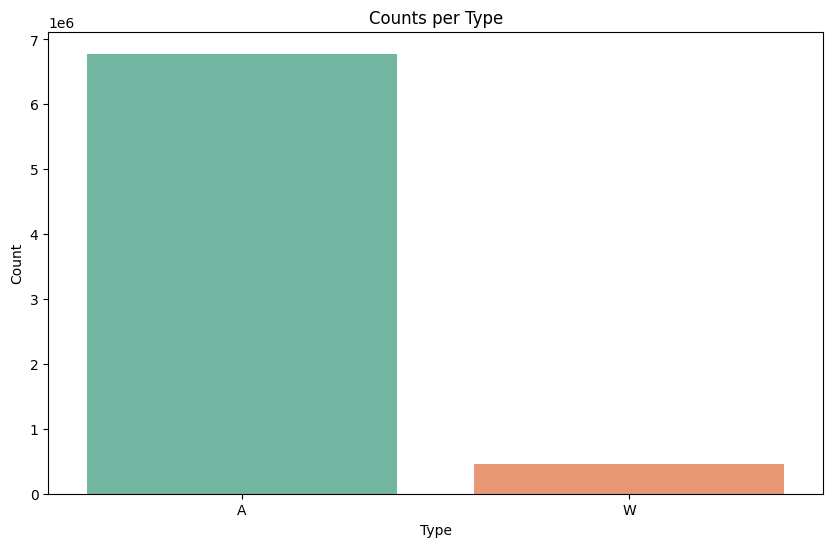

In [10]:
plot_counts_per_type(df_eqix)

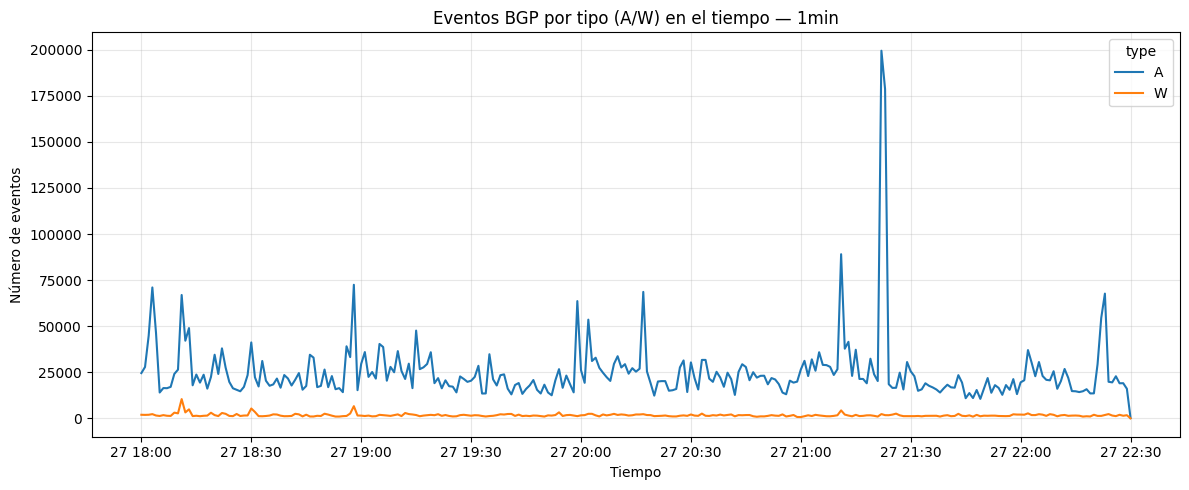

In [11]:
plot_updates_by_type(df_eqix, grain='1min')

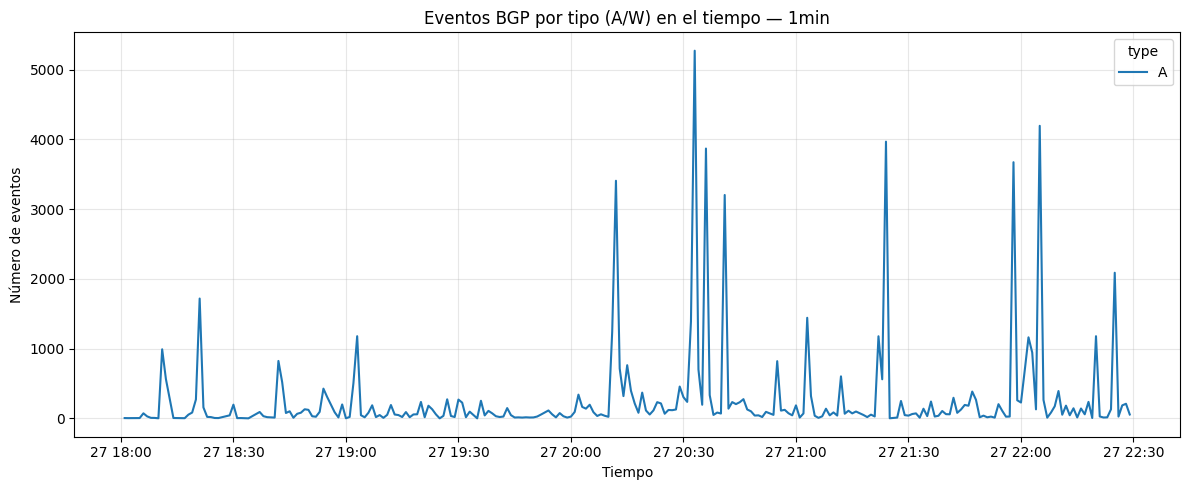

In [12]:
plot_updates_by_type(df_eqix_as_267613, grain='1min')

### Route Views AMSIX

In [4]:
collector = "route-views.amsix"

df_amsix = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_amsix.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1070::/32,2001:7f8:1:0:a500:26:7613:1,267613 28209,None,None,None,"[5469:11111, 5469:2400, 5469:10110]",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1624:9000::/36,2001:7f8:1:0:a500:26:7613:1,267613 174 263444 263270,None,None,None,"[5469:10850, 5469:11000, 5469:2200]",2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a06:de05:61dc::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 174 53667,None,None,None,"[5469:10850, 5469:11000, 5469:2200]",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.amsix,56662,2001:7f8:f2:e1:0:a105:6662:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:a105:6662:1,56662 34549 3257 174 53667,None,None,None,[56662:65008],2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.amsix,213151,2001:7f8:f2:e1:0:21:3151:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:21:3151:1,213151 34549 3257 174 53667,None,None,None,[],2024-06-27 18:00:00
5,1.719511e+09,routeviews,route-views.amsix,38880,80.249.212.75,A,81.192.239.0/24,80.249.212.75,38880 4826 5511 6713 6713 6713 6713 6713 6713 ...,None,None,None,[],2024-06-27 18:00:00
6,1.719511e+09,routeviews,route-views.amsix,38880,2001:7f8:1::a503:8880:1,A,2a06:de05:61dc::/48,2001:7f8:1::a503:8880:1,38880 1299 174 53667,None,None,None,[],2024-06-27 18:00:00
7,1.719511e+09,routeviews,route-views.amsix,1103,80.249.208.50,A,169.145.140.0/23,80.249.208.50,1103 2603 8220 14114 6979 6979 6979 6979 6979 ...,None,None,None,"[14114:199, 8220:64005, 14114:1101, 2603:302, ...",2024-06-27 18:00:00
8,1.719511e+09,routeviews,route-views.amsix,1103,80.249.208.50,A,138.99.97.0/24,80.249.208.50,1103 2603 6762 53013 28370 28370 28657,None,None,None,"[6762:1, 2603:302, 2603:666, 6762:15500, 6762:...",2024-06-27 18:00:00
9,1.719511e+09,routeviews,route-views.amsix,1103,80.249.208.50,A,183.90.160.0/24,80.249.208.50,1103 2603 3491 45899 131126,None,None,None,"[3491:62220, 3491:200, 17152:0, 2603:65101, 26...",2024-06-27 18:00:00


In [5]:
display(df_amsix.info())

amsix_null_stats = pd.DataFrame({
    'nulos': df_amsix.isna().sum(),
    'no_nulos': df_amsix.notna().sum(),
    'pct_nulos': (df_amsix.isna().sum() / len(df_amsix) * 100).round(2)
})
display(amsix_null_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11628213 entries, 0 to 11628212
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.2+ GB


None

,nulos,no_nulos,pct_nulos
time,0,11628213,0.00
project,0,11628213,0.00
collector,0,11628213,0.00
peer_asn,0,11628213,0.00
peer_ip,0,11628213,0.00
type,0,11628213,0.00
prefix,0,11628213,0.00
next_hop,795031,10833182,6.84
as_path,795031,10833182,6.84
origin,11628213,0,100.00


In [8]:
df_amsix = add_as_path_length(df_amsix, new_column_order)
df_amsix.head(5)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1070::/32,2001:7f8:1:0:a500:26:7613:1,267613 28209,2,None,None,None,"[5469:11111, 5469:2400, 5469:10110]"
1,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1624:9000::/36,2001:7f8:1:0:a500:26:7613:1,267613 174 263444 263270,4,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
2,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a06:de05:61dc::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 174 53667,4,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
3,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,56662,2001:7f8:f2:e1:0:a105:6662:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:a105:6662:1,56662 34549 3257 174 53667,5,None,None,None,[56662:65008]
4,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,213151,2001:7f8:f2:e1:0:21:3151:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:21:3151:1,213151 34549 3257 174 53667,5,None,None,None,[]


In [13]:
df_amsix[df_amsix['prefix'].isin(['1.1.1.1/32', '1.1.1.1/24'])]

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities


In [14]:
df_amsix_as_267613 = df_amsix[df_amsix['as_path'].str.contains('267613', na=False)]
df_amsix_as_267613.head(20)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1070::/32,2001:7f8:1:0:a500:26:7613:1,267613 28209,2,None,None,None,"[5469:11111, 5469:2400, 5469:10110]"
1,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1624:9000::/36,2001:7f8:1:0:a500:26:7613:1,267613 174 263444 263270,4,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
2,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a06:de05:61dc::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 174 53667,4,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
39,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,80.249.213.223,A,81.199.84.0/24,80.249.213.223,267613 52320 12491,3,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
40,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,80.249.213.223,A,81.192.239.0/24,80.249.213.223,267613 174 5511 6713 6713 6713 6713 6713 6713 ...,13,None,None,None,"[5469:11000, 5469:2200, 5469:10110]"
41,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.amsix,267613,80.249.213.223,A,197.216.52.0/24,80.249.213.223,267613 174 3356 3741 33763 33763 11259,7,None,None,None,"[5469:11000, 5469:2200, 5469:10110]"
205,1.719511e+09,2024-06-27 18:00:18,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a0c:1040::/29,2001:7f8:1:0:a500:26:7613:1,267613 3356 30781 204382,4,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
206,1.719511e+09,2024-06-27 18:00:18,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a01:6600:2e00::/40,2001:7f8:1:0:a500:26:7613:1,267613 3356 35625,3,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
207,1.719511e+09,2024-06-27 18:00:18,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2001:df7:d80::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 15412 18101 138754,5,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"
208,1.719511e+09,2024-06-27 18:00:18,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2001:df7:4d80::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 15412 18101 138754,5,None,None,None,"[5469:10850, 5469:11000, 5469:2200]"


,type,count
0,A,10833182
1,W,795031


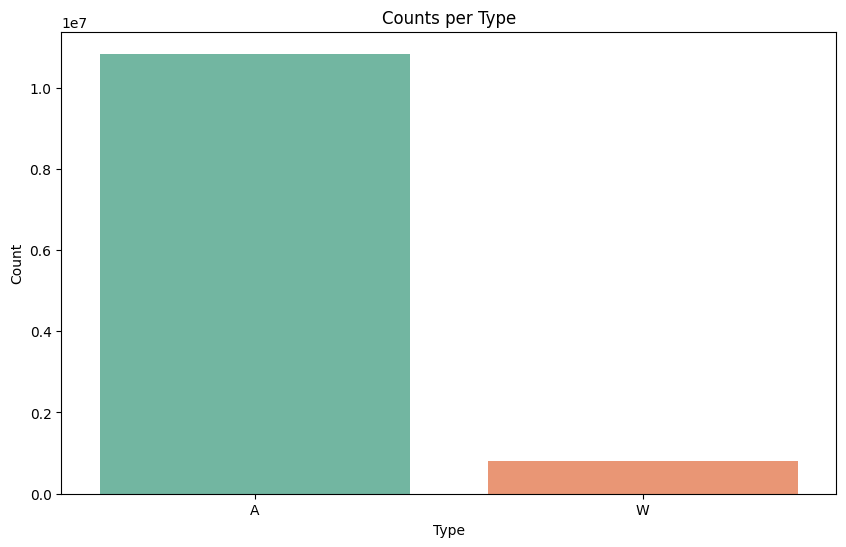

In [15]:
plot_counts_per_type(df_amsix)

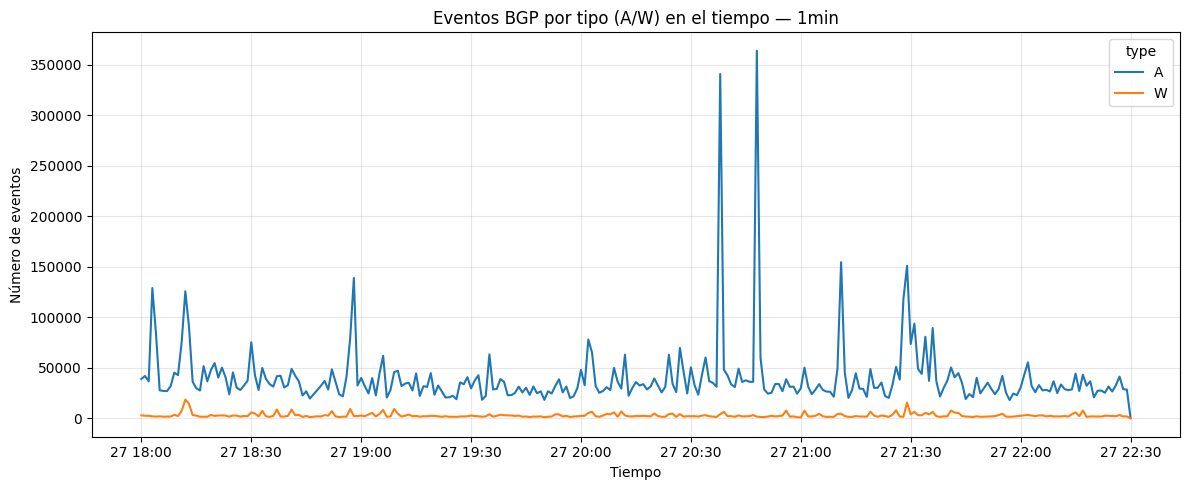

In [16]:
plot_updates_by_type(df_amsix, grain='1min')

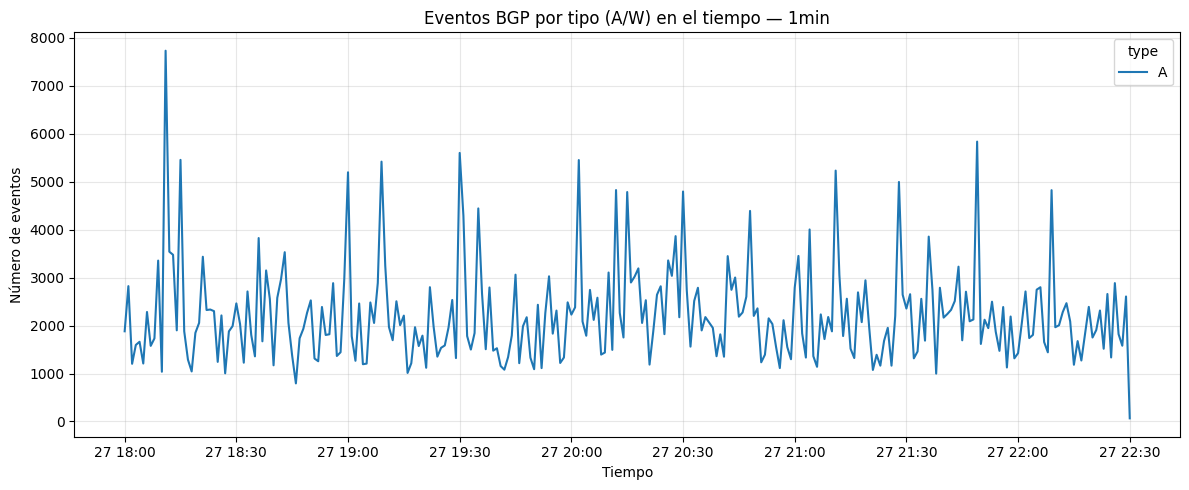

In [17]:
plot_updates_by_type(df_amsix_as_267613, grain='1min')

### Route Views FORTALEZA

In [4]:
collector = "route-views.fortaleza"

df_fortaleza = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_fortaleza.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.fortaleza,199524,2001:12f8:0:9::146:59,A,2803:a5c0:4000::/36,2001:12f8:0:9::146:59,199524 3356 174 262186 262186 273001,None,None,None,[],2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2a06:de05:61dc::/48,2001:12f8:0:9::128,52320 1299 174 53667,None,None,None,[52320:11311],2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2606:ab40:100::/48,2001:12f8:0:9::128,52320 2914 3356 400339,None,None,None,[52320:11912],2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2803:a5c0:4000::/36,2001:12f8:0:9::128,52320 1299 174 262186 262186 273001,None,None,None,[52320:11311],2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2a0c:1040::/29,2001:12f8:0:9::128,52320 1299 30781 204382,None,None,None,[52320:11311],2024-06-27 18:00:00
5,1.719511e+09,routeviews,route-views.fortaleza,267613,45.184.144.102,A,81.199.84.0/24,45.184.144.102,267613 52320 12491,None,None,None,"[5469:2200, 5469:11000, 5469:10850]",2024-06-27 18:00:00
6,1.719511e+09,routeviews,route-views.fortaleza,267613,45.184.144.102,A,81.192.239.0/24,45.184.144.102,267613 174 5511 6713 6713 6713 6713 6713 6713 ...,None,None,None,"[5469:10110, 5469:2200, 5469:11000]",2024-06-27 18:00:00
7,1.719511e+09,routeviews,route-views.fortaleza,267613,45.184.144.102,A,197.216.52.0/24,45.184.144.102,267613 174 3356 3741 33763 33763 11259,None,None,None,"[5469:10110, 5469:2200, 5469:11000]",2024-06-27 18:00:00
8,1.719511e+09,routeviews,route-views.fortaleza,267613,2001:12f8:0:9::102,A,2a0c:1040::/29,2001:12f8:0:9::102,267613 3356 30781 204382,None,None,None,"[5469:2200, 5469:11000, 5469:10850]",2024-06-27 18:00:00
9,1.719511e+09,routeviews,route-views.fortaleza,52320,45.184.144.128,A,81.192.239.0/24,45.184.144.128,52320 174 5511 6713 6713 6713 6713 6713 6713 6...,None,None,None,[52320:11912],2024-06-27 18:00:00


In [5]:
display(df_fortaleza.info())

fortaleza_null_stats = pd.DataFrame({
    'nulos': df_fortaleza.isna().sum(),
    'no_nulos': df_fortaleza.notna().sum(),
    'pct_nulos': (df_fortaleza.isna().sum() / len(df_fortaleza) * 100).round(2)
})
display(fortaleza_null_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3038596 entries, 0 to 3038595
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 324.6+ MB


None

,nulos,no_nulos,pct_nulos
time,0,3038596,0.00
project,0,3038596,0.00
collector,0,3038596,0.00
peer_asn,0,3038596,0.00
peer_ip,0,3038596,0.00
type,0,3038596,0.00
prefix,0,3038596,0.00
next_hop,402548,2636048,13.25
as_path,402548,2636048,13.25
origin,3038596,0,100.00


In [6]:
df_fortaleza = add_as_path_length(df_fortaleza, new_column_order)
df_fortaleza.head(5)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,199524,2001:12f8:0:9::146:59,A,2803:a5c0:4000::/36,2001:12f8:0:9::146:59,199524 3356 174 262186 262186 273001,6,None,None,None,[]
1,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2a06:de05:61dc::/48,2001:12f8:0:9::128,52320 1299 174 53667,4,None,None,None,[52320:11311]
2,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2606:ab40:100::/48,2001:12f8:0:9::128,52320 2914 3356 400339,4,None,None,None,[52320:11912]
3,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2803:a5c0:4000::/36,2001:12f8:0:9::128,52320 1299 174 262186 262186 273001,6,None,None,None,[52320:11311]
4,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,52320,2001:12f8:0:9::128,A,2a0c:1040::/29,2001:12f8:0:9::128,52320 1299 30781 204382,4,None,None,None,[52320:11311]


In [8]:
df_fortaleza[df_fortaleza['prefix'].isin(['1.1.1.1/32','1.1.1.1/24'])]

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities


In [9]:
df_fortaleza_as_267613 = df_fortaleza[df_fortaleza['as_path'].str.contains('267613', na=False)]
df_fortaleza_as_267613.head(20)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
5,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,267613,45.184.144.102,A,81.199.84.0/24,45.184.144.102,267613 52320 12491,3,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
6,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,267613,45.184.144.102,A,81.192.239.0/24,45.184.144.102,267613 174 5511 6713 6713 6713 6713 6713 6713 ...,13,None,None,None,"[5469:10110, 5469:2200, 5469:11000]"
7,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,267613,45.184.144.102,A,197.216.52.0/24,45.184.144.102,267613 174 3356 3741 33763 33763 11259,7,None,None,None,"[5469:10110, 5469:2200, 5469:11000]"
8,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.fortaleza,267613,2001:12f8:0:9::102,A,2a0c:1040::/29,2001:12f8:0:9::102,267613 3356 30781 204382,4,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
11,1.719511e+09,2024-06-27 18:00:05,routeviews,route-views.fortaleza,267613,45.184.144.102,A,91.199.139.0/24,45.184.144.102,267613 1299 174 199995 20934 44495,6,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
12,1.719511e+09,2024-06-27 18:00:05,routeviews,route-views.fortaleza,267613,45.184.144.102,A,91.199.139.0/24,45.184.144.102,267613 52320 1299 174 199995 20934 44495,7,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
13,1.719511e+09,2024-06-27 18:00:05,routeviews,route-views.fortaleza,267613,45.184.144.102,A,91.199.139.0/24,45.184.144.102,267613 52320 6461 174 199995 20934 44495,7,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
14,1.719511e+09,2024-06-27 18:00:05,routeviews,route-views.fortaleza,267613,45.184.144.102,A,123.136.68.0/24,45.184.144.102,267613 3356 23856 139883 23767,5,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
15,1.719511e+09,2024-06-27 18:00:05,routeviews,route-views.fortaleza,267613,45.184.144.102,A,192.122.140.0/24,45.184.144.102,267613 3356 23856 139883 23767,5,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"
16,1.719511e+09,2024-06-27 18:00:05,routeviews,route-views.fortaleza,267613,45.184.144.102,A,192.122.131.0/24,45.184.144.102,267613 3356 23856 139883 23767,5,None,None,None,"[5469:2200, 5469:11000, 5469:10850]"


,type,count
0,A,2636048
1,W,402548


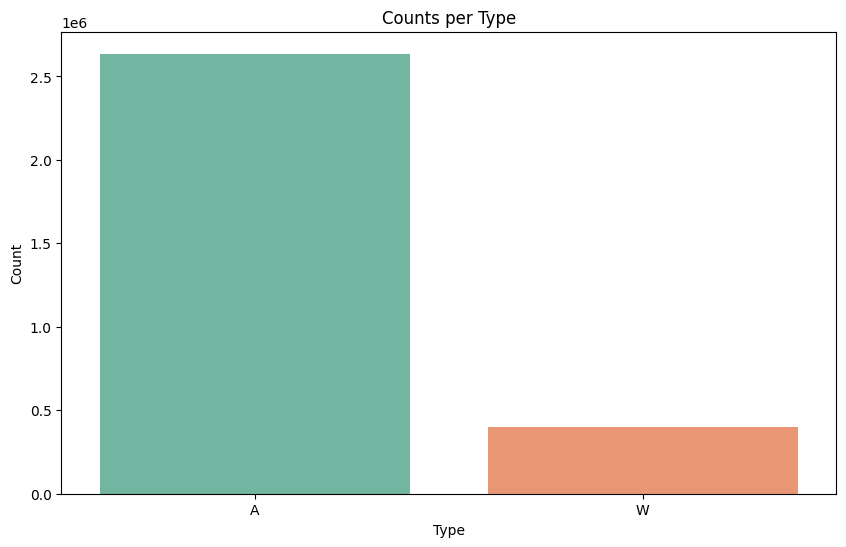

In [11]:
plot_counts_per_type(df_fortaleza)

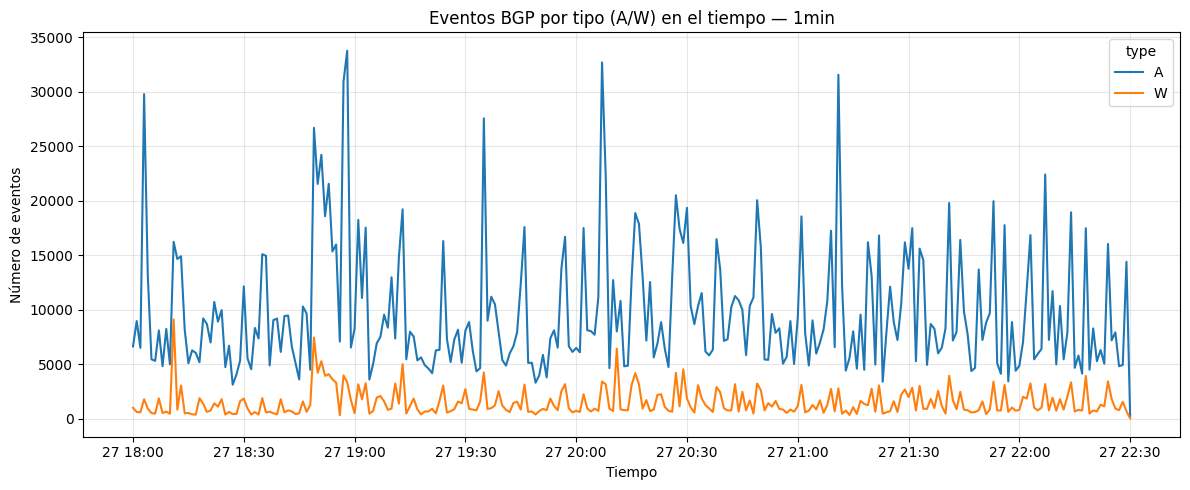

In [12]:
plot_updates_by_type(df_fortaleza, grain='1min')

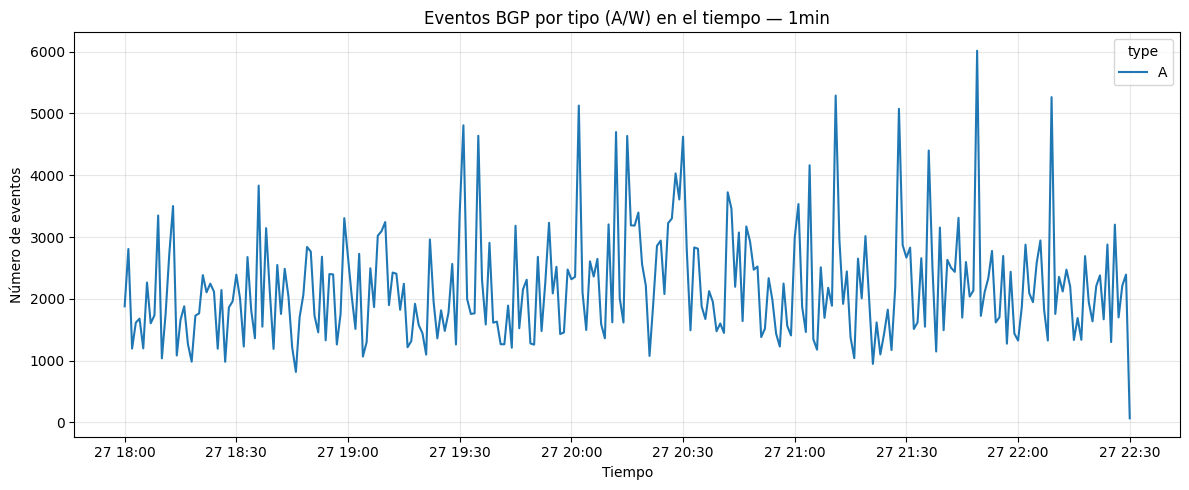

In [13]:
plot_updates_by_type(df_fortaleza_as_267613, grain='1min')

### Route Views NY

In [5]:
collector = "route-views.ny"

df_ny = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_ny.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.ny,49544,206.82.104.63,A,169.145.140.0/23,206.82.104.63,49544 8220 14114 6979 6979 6979 6979 6979 6979,None,None,None,"[49544:24033, 8220:64005, 14114:100, 8220:6540...",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.ny,49544,206.82.104.63,A,169.145.140.0/23,206.82.104.63,49544 8220 14114 6979 6979 6979 6979 6979 6979,None,None,None,"[8220:64005, 14114:100, 8220:65403, 49544:2404...",2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.ny,49544,206.82.104.63,A,91.199.139.0/24,206.82.104.63,49544 1299 174 199995 20934 44495,None,None,None,"[49544:16134, 1299:25000, 49544:16000, 1299:25...",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.ny,49544,2001:504:36::c188:0:1,A,2606:6e00:8000::/35,2001:504:36::c188:0:1,49544 7296,None,None,None,"[49544:14000, 19996:19996, 49544:14106, 7296:1...",2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.ny,49544,2001:504:36::c188:0:1,A,2a10:c5c1:bdae::/48,2001:504:36::c188:0:1,49544 29014 211547,None,None,None,"[65101:4122, 49544:24049, 65102:4000, 49544:24...",2024-06-27 18:00:00
5,1.719511e+09,routeviews,route-views.ny,49544,206.82.104.63,A,130.137.150.0/24,206.82.104.63,49544 16509,None,None,None,"[49544:24049, 49544:24000]",2024-06-27 18:00:00
6,1.719511e+09,routeviews,route-views.ny,49544,206.82.104.63,A,91.199.139.0/24,206.82.104.63,49544 174 3356 199995 20934 44495,None,None,None,"[49544:16134, 174:21000, 49544:16000, 174:22013]",2024-06-27 18:00:00
7,1.719511e+09,routeviews,route-views.ny,398465,206.82.104.185,A,169.145.140.0/23,206.82.104.185,398465 174 3356 14114 6979 6979 6979 6979 6979...,None,None,None,"[174:21000, 174:22013]",2024-06-27 18:00:00
8,1.719511e+09,routeviews,route-views.ny,398465,2001:504:36:0:6:1481:0:1,W,2606:ab40:100::/48,None,None,None,None,None,None,2024-06-27 18:00:00
9,1.719511e+09,routeviews,route-views.ny,398465,2001:504:36:0:6:1481:0:1,W,2a10:ccc7:9367::/48,None,None,None,None,None,None,2024-06-27 18:00:00


In [6]:
display(df_ny.info())

ny_null_stats = pd.DataFrame({
    'nulos': df_ny.isna().sum(),
    'no_nulos': df_ny.notna().sum(),
    'pct_nulos': (df_ny.isna().sum() / len(df_ny) * 100).round(2)
})
display(ny_null_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490349 entries, 0 to 1490348
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   time            1490349 non-null  float64
 1   project         1490349 non-null  object 
 2   collector       1490349 non-null  object 
 3   peer_asn        1490349 non-null  int64  
 4   peer_ip         1490349 non-null  object 
 5   type            1490349 non-null  object 
 6   prefix          1490349 non-null  object 
 7   next_hop        1415419 non-null  object 
 8   as_path         1415419 non-null  object 
 9   origin          0 non-null        object 
 10  local_pref      0 non-null        object 
 11  med             0 non-null        object 
 12  communities     1415419 non-null  object 
 13  formatted_time  1490349 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 159.2+ MB


None

,nulos,no_nulos,pct_nulos
time,0,1490349,0.00
project,0,1490349,0.00
collector,0,1490349,0.00
peer_asn,0,1490349,0.00
peer_ip,0,1490349,0.00
type,0,1490349,0.00
prefix,0,1490349,0.00
next_hop,74930,1415419,5.03
as_path,74930,1415419,5.03
origin,1490349,0,100.00


In [7]:
df_ny = add_as_path_length(df_ny, new_column_order)
df_ny.head(5)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.ny,49544,206.82.104.63,A,169.145.140.0/23,206.82.104.63,49544 8220 14114 6979 6979 6979 6979 6979 6979,9,None,None,None,"[49544:24033, 8220:64005, 14114:100, 8220:6540..."
1,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.ny,49544,206.82.104.63,A,169.145.140.0/23,206.82.104.63,49544 8220 14114 6979 6979 6979 6979 6979 6979,9,None,None,None,"[8220:64005, 14114:100, 8220:65403, 49544:2404..."
2,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.ny,49544,206.82.104.63,A,91.199.139.0/24,206.82.104.63,49544 1299 174 199995 20934 44495,6,None,None,None,"[49544:16134, 1299:25000, 49544:16000, 1299:25..."
3,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.ny,49544,2001:504:36::c188:0:1,A,2606:6e00:8000::/35,2001:504:36::c188:0:1,49544 7296,2,None,None,None,"[49544:14000, 19996:19996, 49544:14106, 7296:1..."
4,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.ny,49544,2001:504:36::c188:0:1,A,2a10:c5c1:bdae::/48,2001:504:36::c188:0:1,49544 29014 211547,3,None,None,None,"[65101:4122, 49544:24049, 65102:4000, 49544:24..."


In [8]:
df_ny[df_ny['prefix'].isin(['1.1.1.1/32','1.1.1.1/24'])]

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
339444,1.719514e+09,2024-06-27 18:52:57,routeviews,route-views.ny,398465,206.82.104.185,A,1.1.1.1/32,206.82.104.185,398465 267613,2,None,None,None,[13538:1]
468989,1.719516e+09,2024-06-27 19:15:29,routeviews,route-views.ny,398465,206.82.104.185,W,1.1.1.1/32,None,None,0,None,None,None,None
483665,1.719516e+09,2024-06-27 19:18:59,routeviews,route-views.ny,398465,206.82.104.185,A,1.1.1.1/32,206.82.104.185,398465 267613,2,None,None,None,[13538:1]
595183,1.719517e+09,2024-06-27 19:41:47,routeviews,route-views.ny,398465,206.82.104.185,W,1.1.1.1/32,None,None,0,None,None,None,None
613676,1.719518e+09,2024-06-27 19:46:02,routeviews,route-views.ny,398465,206.82.104.185,A,1.1.1.1/32,206.82.104.185,398465 267613,2,None,None,None,[13538:1]
718901,1.719519e+09,2024-06-27 20:07:49,routeviews,route-views.ny,398465,206.82.104.185,W,1.1.1.1/32,None,None,0,None,None,None,None
745514,1.719519e+09,2024-06-27 20:11:49,routeviews,route-views.ny,398465,206.82.104.185,A,1.1.1.1/32,206.82.104.185,398465 267613,2,None,None,None,[13538:1]
858492,1.719520e+09,2024-06-27 20:33:20,routeviews,route-views.ny,398465,206.82.104.185,W,1.1.1.1/32,None,None,0,None,None,None,None
1319492,1.719525e+09,2024-06-27 21:53:07,routeviews,route-views.ny,398465,206.82.104.185,A,1.1.1.1/32,206.82.104.185,398465 267613,2,None,None,None,[13538:1]
1429519,1.719527e+09,2024-06-27 22:15:53,routeviews,route-views.ny,398465,206.82.104.185,W,1.1.1.1/32,None,None,0,None,None,None,None


In [9]:
df_ny_as_267613 = df_ny[df_ny['as_path'].str.contains('267613', na=False)]
df_ny_as_267613.head(20)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
41787,1.719512e+09,2024-06-27 18:06:26,routeviews,route-views.ny,398465,206.82.104.185,A,45.237.2.0/24,206.82.104.185,398465 267613 268330 268330 268330 268330,6,None,None,None,"[65101:2083, 65104:19, 65102:2000, 65103:840]"
42152,1.719512e+09,2024-06-27 18:06:30,routeviews,route-views.ny,398465,206.82.104.185,A,201.49.142.0/24,206.82.104.185,398465 267613 268503 268503 263935 270571 2705...,10,None,None,None,"[65101:2083, 65104:19, 65102:2000, 65103:840]"
42153,1.719512e+09,2024-06-27 18:06:30,routeviews,route-views.ny,398465,206.82.104.185,A,201.49.143.0/24,206.82.104.185,398465 267613 268503 268503 263935 270571 270571,7,None,None,None,"[65101:2083, 65104:19, 65102:2000, 65103:840]"
42154,1.719512e+09,2024-06-27 18:06:30,routeviews,route-views.ny,398465,206.82.104.185,A,201.49.142.0/23,206.82.104.185,398465 267613 268503 268503 263935 270571 2705...,9,None,None,None,"[65101:2083, 65104:19, 65102:2000, 65103:840]"
42345,1.719512e+09,2024-06-27 18:06:33,routeviews,route-views.ny,49544,206.82.104.63,A,131.72.33.0/24,206.82.104.63,49544 267613 28343 61711,4,None,None,None,"[49544:24044, 49544:24000]"
42347,1.719512e+09,2024-06-27 18:06:33,routeviews,route-views.ny,49544,206.82.104.63,A,131.72.33.0/24,206.82.104.63,49544 267613 28343 61711,4,None,None,None,"[49544:24031, 49544:24000]"
42352,1.719512e+09,2024-06-27 18:06:33,routeviews,route-views.ny,49544,206.82.104.63,A,131.72.33.0/24,206.82.104.63,49544 1299 267613 28343 61711,5,None,None,None,"[1299:35810, 49544:16134, 1299:35000, 49544:16..."
48033,1.719512e+09,2024-06-27 18:07:48,routeviews,route-views.ny,49544,206.82.104.63,A,131.72.32.0/23,206.82.104.63,49544 267613 28343 61711,4,None,None,None,"[0:52965, 0:22356, 0:28604, 0:28283, 0:28202, ..."
48050,1.719512e+09,2024-06-27 18:07:48,routeviews,route-views.ny,49544,206.82.104.63,A,131.72.32.0/23,206.82.104.63,49544 267613 28343 61711,4,None,None,None,"[49544:14134, 0:52965, 0:22356, 0:28604, 0:282..."
48051,1.719512e+09,2024-06-27 18:07:48,routeviews,route-views.ny,49544,206.82.104.63,A,131.72.32.0/23,206.82.104.128,49544 267613 28343 61711,4,None,None,None,"[49544:14134, 0:52965, 0:22356, 0:28604, 0:282..."


,type,count
0,A,1415419
1,W,74930


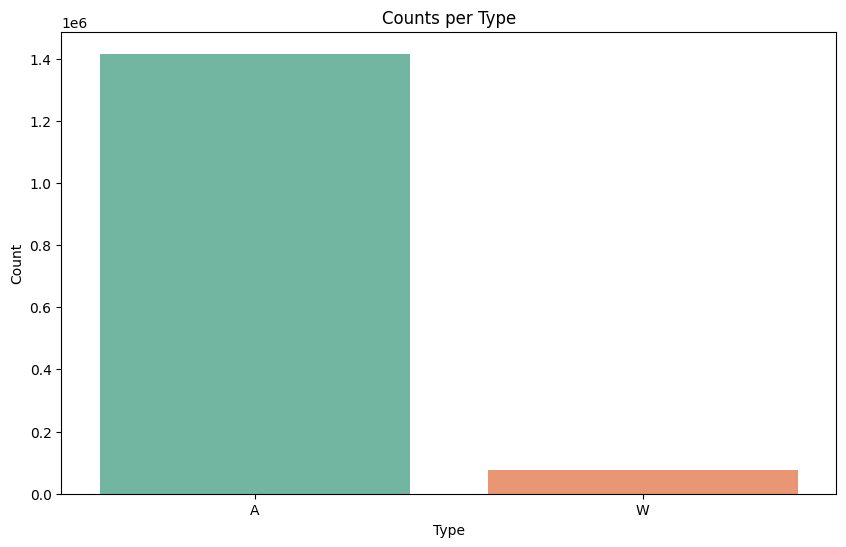

In [10]:
plot_counts_per_type(df_ny)

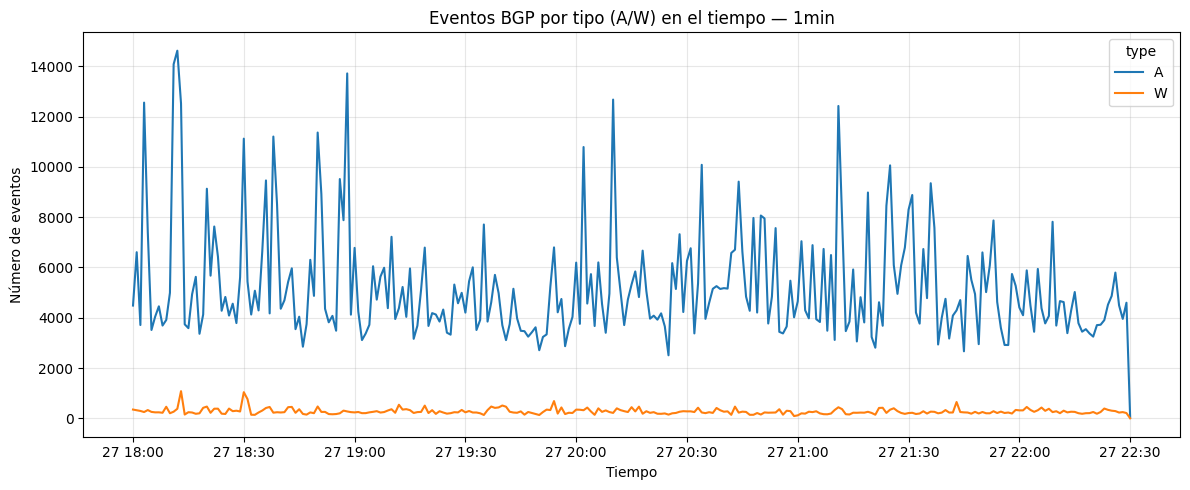

In [11]:
plot_updates_by_type(df_ny, grain='1min')

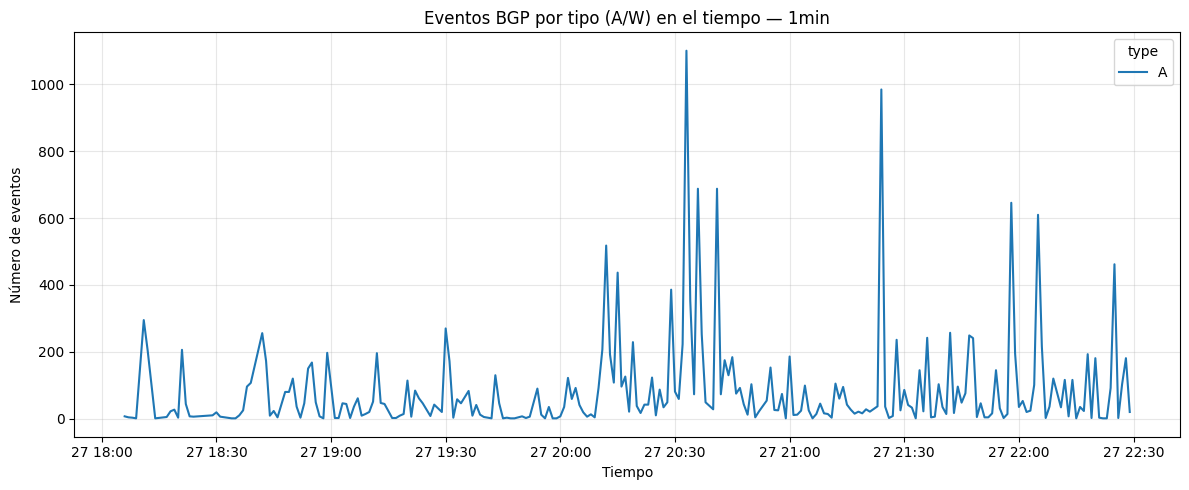

In [12]:
plot_updates_by_type(df_ny_as_267613, grain='1min')

### Route Views TELXATL

In [4]:
collector = "route-views.telxatl"

df_telxatl = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_telxatl.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.telxatl,4181,198.32.132.28,W,81.192.239.0/24,None,None,None,None,None,None,2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.203.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,None,None,None,[],2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.200.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,None,None,None,[],2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.202.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,None,None,None,[],2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.201.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,None,None,None,[],2024-06-27 18:00:00
5,1.719511e+09,routeviews,route-views.telxatl,4181,2001:478:132::28,A,2803:a5c0:4000::/36,2001:478:132::28,4181 1299 262589 262186 273001,None,None,None,"[4181:965, 1299:35000]",2024-06-27 18:00:00
6,1.719511e+09,routeviews,route-views.telxatl,4181,198.32.132.28,A,81.192.239.0/24,198.32.132.28,4181 3257 5511 6713 6713 6713 6713 6713 6713 6...,None,None,None,"[3257:30036, 3257:50002, 3257:8156, 3257:51102...",2024-06-27 18:00:00
7,1.719511e+09,routeviews,route-views.telxatl,4181,198.32.132.28,A,169.145.140.0/23,198.32.132.28,4181 3257 3356 14114 6979 6979 6979 6979 6979 ...,None,None,None,"[3257:51300, 3257:30414, 3257:8055, 3257:8173,...",2024-06-27 18:00:00
8,1.719511e+09,routeviews,route-views.telxatl,4181,2001:478:132::28,A,2803:a5c0:4000::/36,2001:478:132::28,4181 1299 262589 262186 273001,None,None,None,"[4181:965, 1299:35000]",2024-06-27 18:00:00
9,1.719511e+09,routeviews,route-views.telxatl,6939,198.32.132.75,A,102.130.106.0/24,198.32.132.75,6939 328748 328068,None,None,None,[],2024-06-27 18:00:00


In [5]:
display(df_telxatl.info())

telxatl_null_stats = pd.DataFrame({
    'nulos': df_telxatl.isna().sum(),
    'no_nulos': df_telxatl.notna().sum(),
    'pct_nulos': (df_telxatl.isna().sum() / len(df_telxatl) * 100).round(2)
})
display(telxatl_null_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8487993 entries, 0 to 8487992
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 906.6+ MB


None

,nulos,no_nulos,pct_nulos
time,0,8487993,0.00
project,0,8487993,0.00
collector,0,8487993,0.00
peer_asn,0,8487993,0.00
peer_ip,0,8487993,0.00
type,0,8487993,0.00
prefix,0,8487993,0.00
next_hop,147295,8340698,1.74
as_path,147295,8340698,1.74
origin,8487993,0,100.00


In [6]:
df_telxatl = add_as_path_length(df_telxatl, new_column_order)
df_telxatl.head(5)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.telxatl,4181,198.32.132.28,W,81.192.239.0/24,None,None,0,None,None,None,None
1,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.203.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,7,None,None,None,[]
2,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.200.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,7,None,None,None,[]
3,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.202.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,7,None,None,None,[]
4,1.719511e+09,2024-06-27 18:00:00,routeviews,route-views.telxatl,199524,198.32.132.241,A,103.136.201.0/24,198.32.132.241,199524 6453 132884 150178 138692 138692 138692,7,None,None,None,[]


In [7]:
df_telxatl[df_telxatl['prefix'].isin(['1.1.1.1/32','1.1.1.1/24']) ]

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
3067907,1.719514e+09,2024-06-27 18:53:08,routeviews,route-views.telxatl,13760,198.32.132.129,A,1.1.1.1/32,198.32.132.129,13760 267613,2,None,None,None,[]
4176990,1.719516e+09,2024-06-27 19:16:40,routeviews,route-views.telxatl,13760,198.32.132.129,W,1.1.1.1/32,None,None,0,None,None,None,None
4376284,1.719516e+09,2024-06-27 19:19:10,routeviews,route-views.telxatl,13760,198.32.132.129,A,1.1.1.1/32,198.32.132.129,13760 267613,2,None,None,None,[]
5682718,1.719517e+09,2024-06-27 19:42:10,routeviews,route-views.telxatl,13760,198.32.132.129,W,1.1.1.1/32,None,None,0,None,None,None,None
5716899,1.719518e+09,2024-06-27 19:46:10,routeviews,route-views.telxatl,13760,198.32.132.129,A,1.1.1.1/32,198.32.132.129,13760 267613,2,None,None,None,[]
5919352,1.719519e+09,2024-06-27 20:08:10,routeviews,route-views.telxatl,13760,198.32.132.129,W,1.1.1.1/32,None,None,0,None,None,None,None
5948481,1.719519e+09,2024-06-27 20:12:10,routeviews,route-views.telxatl,13760,198.32.132.129,A,1.1.1.1/32,198.32.132.129,13760 267613,2,None,None,None,[]
6156813,1.719520e+09,2024-06-27 20:33:41,routeviews,route-views.telxatl,13760,198.32.132.129,W,1.1.1.1/32,None,None,0,None,None,None,None
7073290,1.719525e+09,2024-06-27 21:53:13,routeviews,route-views.telxatl,13760,198.32.132.129,A,1.1.1.1/32,198.32.132.129,13760 267613,2,None,None,None,[]
7680999,1.719526e+09,2024-06-27 21:58:43,routeviews,route-views.telxatl,13760,198.32.132.129,W,1.1.1.1/32,None,None,0,None,None,None,None


In [8]:
df_telxatl_as_267613 = df_telxatl[df_telxatl['as_path'].str.contains('267613', na=False)]
df_telxatl_as_267613.head(20)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
9313,1.719511e+09,2024-06-27 18:01:14,routeviews,route-views.telxatl,199524,198.32.132.241,A,138.219.97.0/24,198.32.132.241,199524 6453 3356 267613 263922,5,None,None,None,[]
9314,1.719511e+09,2024-06-27 18:01:14,routeviews,route-views.telxatl,199524,198.32.132.241,A,138.219.99.0/24,198.32.132.241,199524 6453 3356 267613 263922,5,None,None,None,[]
9315,1.719511e+09,2024-06-27 18:01:14,routeviews,route-views.telxatl,199524,198.32.132.241,A,138.219.96.0/24,198.32.132.241,199524 6453 3356 267613 263922,5,None,None,None,[]
14939,1.719511e+09,2024-06-27 18:02:00,routeviews,route-views.telxatl,6082,198.32.132.152,A,138.219.97.0/24,198.32.132.152,6082 2914 3356 267613 263922,5,None,None,None,"[2914:1002, 2914:420, 2914:3000, 2914:2000, 60..."
14940,1.719511e+09,2024-06-27 18:02:00,routeviews,route-views.telxatl,6082,198.32.132.152,A,138.219.99.0/24,198.32.132.152,6082 2914 3356 267613 263922,5,None,None,None,"[2914:1002, 2914:420, 2914:3000, 2914:2000, 60..."
14941,1.719511e+09,2024-06-27 18:02:00,routeviews,route-views.telxatl,6082,198.32.132.152,A,138.219.96.0/24,198.32.132.152,6082 2914 3356 267613 263922,5,None,None,None,"[2914:1002, 2914:420, 2914:3000, 2914:2000, 60..."
87078,1.719512e+09,2024-06-27 18:05:43,routeviews,route-views.telxatl,6082,198.32.132.152,A,45.166.212.0/22,198.32.132.152,6082 174 267613 267546,4,None,None,None,"[174:21301, 174:22042, 6082:103]"
88177,1.719512e+09,2024-06-27 18:05:51,routeviews,route-views.telxatl,19151,198.32.132.12,A,45.181.100.0/23,198.32.132.12,19151 174 267613 269182,4,None,None,None,[]
88213,1.719512e+09,2024-06-27 18:05:51,routeviews,route-views.telxatl,19151,198.32.132.12,A,45.166.212.0/22,198.32.132.12,19151 174 267613 267546,4,None,None,None,[]
88214,1.719512e+09,2024-06-27 18:05:51,routeviews,route-views.telxatl,19151,198.32.132.12,A,45.181.100.0/22,198.32.132.12,19151 174 267613 269182,4,None,None,None,[]


,type,count
0,A,8340698
1,W,147295


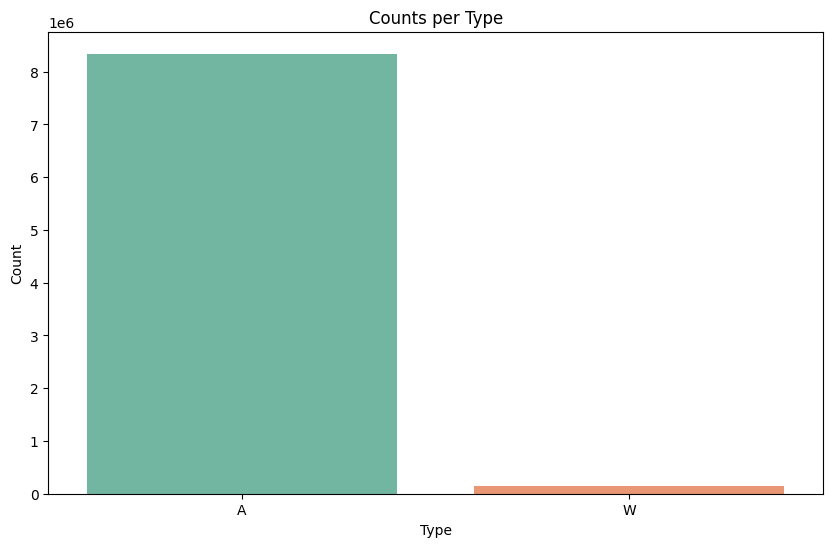

In [9]:
plot_counts_per_type(df_telxatl)

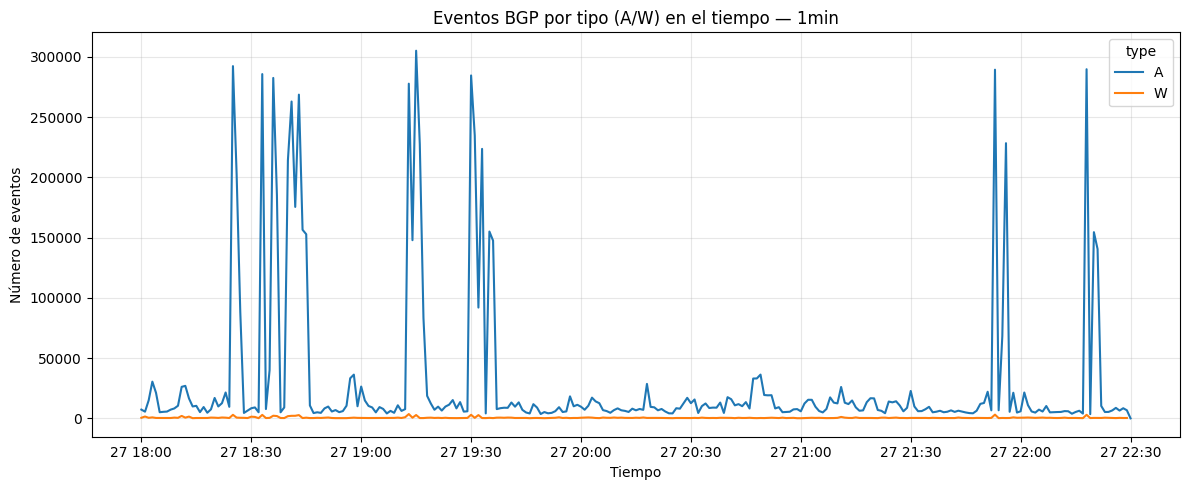

In [10]:
plot_updates_by_type(df_telxatl, grain='1min')

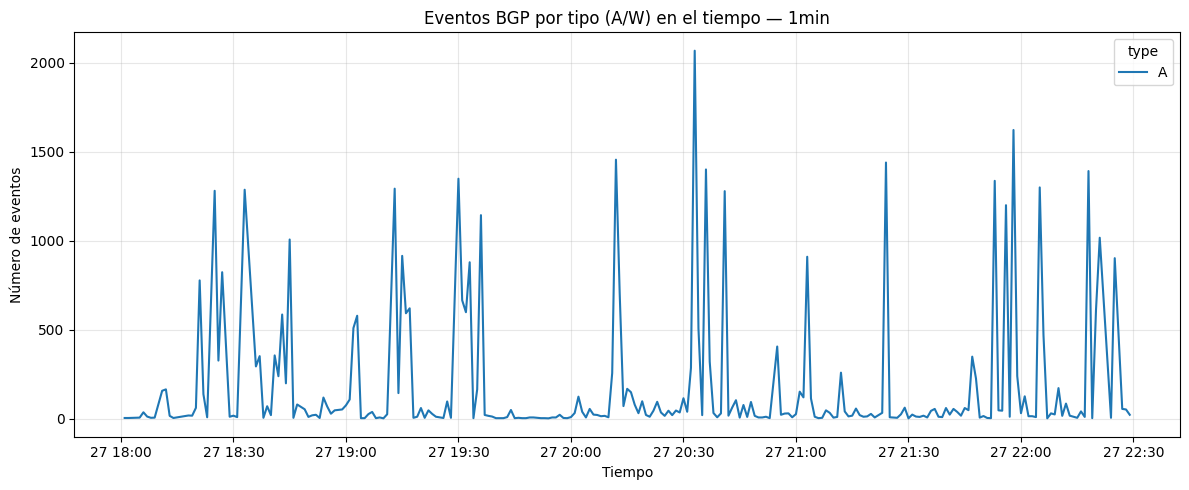

In [11]:
plot_updates_by_type(df_telxatl_as_267613, grain='1min')

### Route Views SAOPAULO

In [4]:
collector = "route-views2.saopaulo"

df_saopaulo = pd.read_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
                             engine='pyarrow')

df_saopaulo.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2c0f:fda8::/32,2001:12f8::208:180,52468 6939 37662 9498 36926 327708 37133 37349,None,None,None,"[52468:2055, 52468:55501, 52468:330, 24115:693...",2024-06-27 18:00:26
1,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2a0e:97c4:af11::/48,2001:12f8::208:180,52468 52320 1299 3257 20473,None,None,None,"[52320:11311, 52468:55501, 52468:2055, 52468:320]",2024-06-27 18:00:26
2,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:fe0f::/48,2001:12f8::208:180,52468 52320 35280 12654,None,None,None,"[52320:21311, 52468:55501, 52468:2055, 52468:320]",2024-06-27 18:00:26
3,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2a0c:1040::/29,2001:12f8::208:180,52468 52320 1299 30781 204382,None,None,None,"[52468:320, 52468:55501, 52468:2055, 52320:11912]",2024-06-27 18:00:26
4,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:ee04::/48,2001:12f8::208:180,52468 6939 4637 38008 46997 12654,None,None,None,"[52468:2055, 52468:55501, 52468:330, 24115:693...",2024-06-27 18:00:26
5,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:ff02::/48,2001:12f8::208:180,52468 6939 12654,None,None,None,"[52468:2055, 52468:55501, 52468:330, 24115:693...",2024-06-27 18:00:26
6,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:fe14::/48,2001:12f8::208:180,52468 52320 48362 12654,None,None,None,"[52320:21311, 52468:55501, 52468:2055, 52468:320]",2024-06-27 18:00:26
7,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2a10:ccc7:9367::/48,2001:12f8::208:180,52468 52320 6461 3356 20473,None,None,None,"[52320:11311, 52468:55501, 52468:2055, 52468:320]",2024-06-27 18:00:26
8,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:fe01::/48,2001:12f8::208:180,52468 52320 3214 12654,None,None,None,"[52320:21311, 52468:55501, 52468:2055, 52468:320]",2024-06-27 18:00:26
9,1.719511e+09,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:fe14::/48,2001:12f8::208:180,52468 52320 8218 12654,None,None,None,"[52320:21311, 52468:55501, 52468:2055, 52468:320]",2024-06-27 18:00:26


In [5]:
display(df_saopaulo.info())

saopaulo_null_stats = pd.DataFrame({
    'nulos': df_saopaulo.isna().sum(),
    'no_nulos': df_saopaulo.notna().sum(),
    'pct_nulos': (df_saopaulo.isna().sum() / len(df_saopaulo) * 100).round(2)
})
display(saopaulo_null_stats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7441003 entries, 0 to 7441002
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 794.8+ MB


None

,nulos,no_nulos,pct_nulos
time,0,7441003,0.00
project,0,7441003,0.00
collector,0,7441003,0.00
peer_asn,0,7441003,0.00
peer_ip,0,7441003,0.00
type,0,7441003,0.00
prefix,0,7441003,0.00
next_hop,474720,6966283,6.38
as_path,474720,6966283,6.38
origin,7441003,0,100.00


In [6]:
df_saopaulo = add_as_path_length(df_saopaulo, new_column_order)
df_saopaulo.head(5)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
0,1.719511e+09,2024-06-27 18:00:26,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2c0f:fda8::/32,2001:12f8::208:180,52468 6939 37662 9498 36926 327708 37133 37349,8,None,None,None,"[52468:2055, 52468:55501, 52468:330, 24115:693..."
1,1.719511e+09,2024-06-27 18:00:26,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2a0e:97c4:af11::/48,2001:12f8::208:180,52468 52320 1299 3257 20473,5,None,None,None,"[52320:11311, 52468:55501, 52468:2055, 52468:320]"
2,1.719511e+09,2024-06-27 18:00:26,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:fe0f::/48,2001:12f8::208:180,52468 52320 35280 12654,4,None,None,None,"[52320:21311, 52468:55501, 52468:2055, 52468:320]"
3,1.719511e+09,2024-06-27 18:00:26,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2a0c:1040::/29,2001:12f8::208:180,52468 52320 1299 30781 204382,5,None,None,None,"[52468:320, 52468:55501, 52468:2055, 52320:11912]"
4,1.719511e+09,2024-06-27 18:00:26,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2001:7fb:ee04::/48,2001:12f8::208:180,52468 6939 4637 38008 46997 12654,6,None,None,None,"[52468:2055, 52468:55501, 52468:330, 24115:693..."


In [7]:
df_saopaulo[df_saopaulo['prefix'].isin(['1.1.1.1/32','1.1.1.1/24'])]

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities


In [8]:
df_saopaulo_as_267613 = df_saopaulo[df_saopaulo['as_path'].str.contains('267613', na=False)]
df_saopaulo_as_267613.head(20)

,time,formatted_time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,as_path_length,origin,local_pref,med,communities
37435,1.719511e+09,2024-06-27 18:01:34,routeviews,route-views2.saopaulo,53427,187.16.214.101,A,138.219.96.0/24,187.16.214.101,53427 6453 174 267613 263922,5,None,None,None,"[6453:5000, 6453:5100, 6453:5102, 53427:6453, ..."
37436,1.719511e+09,2024-06-27 18:01:34,routeviews,route-views2.saopaulo,53427,187.16.214.101,A,138.219.99.0/24,187.16.214.101,53427 6453 174 267613 263922,5,None,None,None,"[6453:5000, 6453:5100, 6453:5102, 53427:6453, ..."
37437,1.719511e+09,2024-06-27 18:01:34,routeviews,route-views2.saopaulo,53427,187.16.214.101,A,138.219.97.0/24,187.16.214.101,53427 6453 174 267613 263922,5,None,None,None,"[6453:5000, 6453:5100, 6453:5102, 53427:6453, ..."
41421,1.719511e+09,2024-06-27 18:01:38,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2804:fe0:24a0::/44,2001:12f8::208:180,52468 52320 267613 263049 263049 263049 263049...,8,None,None,None,"[52320:6030, 52320:6010, 24115:52320, 52320:61..."
41422,1.719511e+09,2024-06-27 18:01:38,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2804:fe0:2400::/44,2001:12f8::208:180,52468 52320 267613 263049 263049 263049 263049...,8,None,None,None,"[52320:6030, 52320:6010, 24115:52320, 52320:61..."
41423,1.719511e+09,2024-06-27 18:01:38,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2804:fe0:1::/48,2001:12f8::208:180,52468 52320 267613 263049 263049 263049 263049...,8,None,None,None,"[52320:6030, 52320:6010, 24115:52320, 52320:61..."
41424,1.719511e+09,2024-06-27 18:01:38,routeviews,route-views2.saopaulo,52468,2001:12f8::208:180,A,2804:fe0:2::/48,2001:12f8::208:180,52468 52320 267613 263049 263049 263049 263049...,8,None,None,None,"[52320:6030, 52320:6010, 24115:52320, 52320:61..."
41524,1.719511e+09,2024-06-27 18:01:39,routeviews,route-views2.saopaulo,263009,2001:12f8::222:221,A,2804:fe0:1::/48,2001:12f8::222:221,263009 52320 267613 263049 263049 263049 26304...,8,None,None,None,[]
41525,1.719511e+09,2024-06-27 18:01:39,routeviews,route-views2.saopaulo,263009,2001:12f8::222:221,A,2804:fe0:2400::/44,2001:12f8::222:221,263009 52320 267613 263049 263049 263049 26304...,8,None,None,None,[]
41526,1.719511e+09,2024-06-27 18:01:39,routeviews,route-views2.saopaulo,263009,2001:12f8::222:221,A,2804:fe0:24a0::/44,2001:12f8::222:221,263009 52320 267613 263049 263049 263049 26304...,8,None,None,None,[]


,type,count
0,A,6966283
1,W,474720


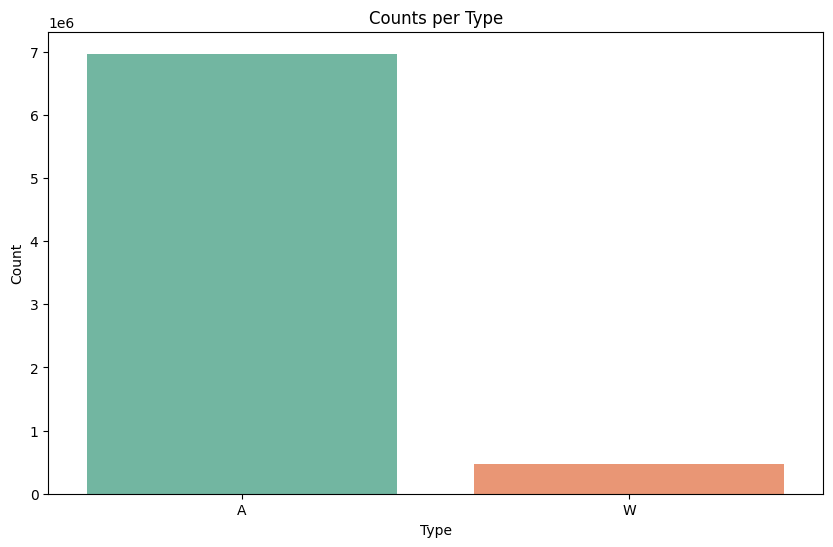

In [9]:
plot_counts_per_type(df_saopaulo)

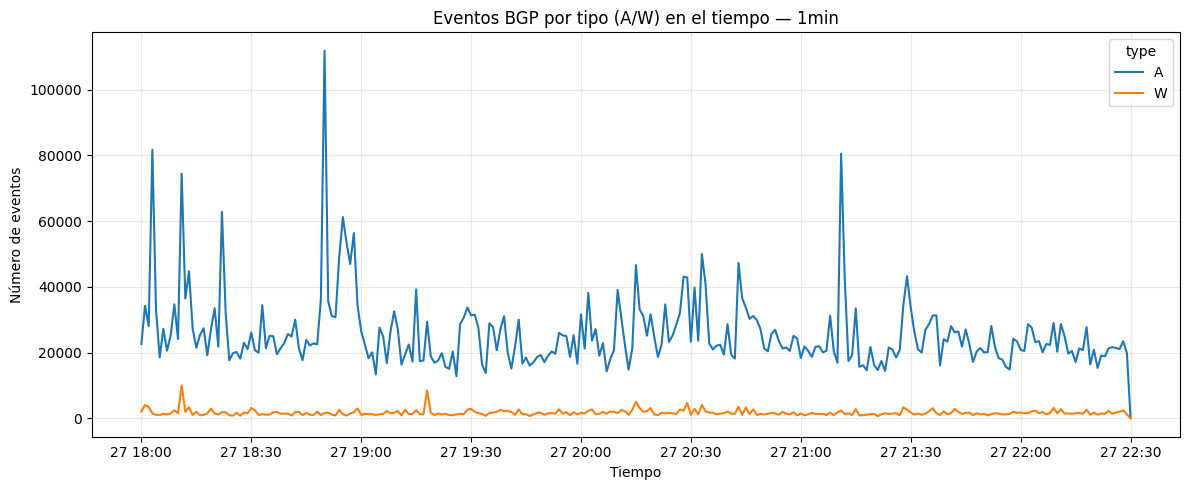

In [10]:
plot_updates_by_type(df_saopaulo, grain='1min')

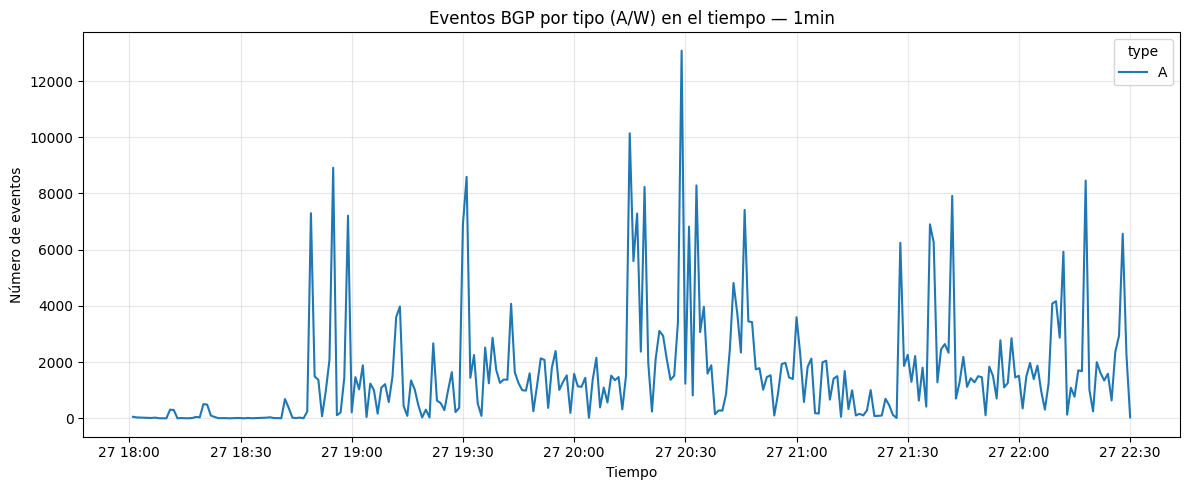

In [11]:
plot_updates_by_type(df_saopaulo_as_267613, grain='1min')